In [1]:
# 初めの一回だけこのセルを実行してください、データセットをダウンロードして展開します
# 一回実行すれば、データセットはダウンロードされたままなので、再起動後等再び実行する必要はありません
import urllib.request
import zipfile

# URLを指定
url = "https://storage.googleapis.com/tutor-contents-dataset/5060_tsa_data.zip"
save_name = url.split('/')[-1]

# ダウンロードする
mem = urllib.request.urlopen(url).read()

# ファイルへ保存
with open(save_name, mode='wb') as f:
    f.write(mem)

# zipファイルをカレントディレクトリに展開する
zfile = zipfile.ZipFile(save_name)
zfile.extractall('.')

In [4]:
#モジュールのインポート
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

# 1.データの読み込み
df = pd.read_csv("/content/monthly-car-sales-in-quebec-1960.csv")

# 日付を月ごとにしてindexにdatetime型に格納する。⇒時系列解析のデータ整形。
index = pd.date_range("1960-01-31","1968-12-31",freq="M")
df.index=index

# 上記の整形により不要になったカラム["Month"]の削除
del df["Month"]

In [5]:
#データの分割
#便宜上 y を作成。当然元データと同じ
y = df[["sales"]]

#それじゃあデータ分割。trainを分割。⇒ y があるためこのようにデータ分割可能。
from sklearn.model_selection import train_test_split
train_X,test_X, train_y,test_y  = train_test_split(df,y,random_state=42, shuffle=False)

In [ ]:
#グリッドサーチ
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX


p = q = range(0, 3)
sp = sd = sq = range(0, 2)

pdq = [(x[0], 1, x[1]) for x in list(itertools.product(p, q))] # 3*3 9パターン

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))] # 2*2*2 8パターン　　72パターン。

# worningの無視。
import warnings
warnings.filterwarnings("ignore")

# AICが低かったら更新すると。

best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train_X, order = param, seasonal_order = param_seasonal)
            results = mod.fit()
            print('ARIMAパラメータ{}, 季節変動パラメータ{} - AIC: {}'.format(param, param_seasonal, results.aic))
            
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue

print('AIC最小のモデル：', best_result)

In [9]:
#学習

#パラメータの設定. 学習用データ train_Xを格納
sarima_model2 = SARIMAX(train_X,order=(1,1,1),seasonal_order=(1,1,0,12))

#モデルフィット。インスタンス化
sarima_model2 = sarima_model2.fit()
sarima_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              sales   No. Observations:                   81
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -596.032
Date:                            Tue, 09 Aug 2022   AIC                           1200.064
Time:                                    05:09:21   BIC                           1208.942
Sample:                                01-31-1960   HQIC                          1203.582
                                     - 09-30-1966                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3380      0.123      2.756      0.006       0.098       0.578
ma.L1         -0.9959      0.466     -2.137      0.033      -1.909      -0.082
ar.S.L12      -0.4522      0.126     -3.587      0.000      -0.699      -0.205
sigma2      2.071e+06   9.84e+05      2.104      0.035    1.42e+05       4e+06
===================================================================================
Ljung-Box (Q):                       67.66   Jarque-Bera (JB):                 1.59
Prob(Q):                              0.00   Prob(JB):                         0.45
Heteroskedasticity (H):               1.08   Skew:                             0.37
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
test_y

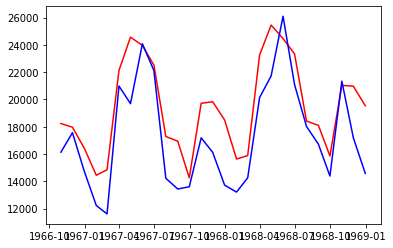

RMSE 2696.610792020013


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# 予測⇒どの機関を予測するのかはtest_yで確認。⇒日付だけはtest_yとpred双方とも合致していると確認。
pred = sarima_model2.predict("1966-10-31","1968-12-31")

#1つ目のデータをplotメソッドでプロット
plt.plot(pred, color = 'red')

#2つ目のデータをplotメソッドでプロット
plt.plot(test_y, color = 'blue')
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error as MSE
# y_trainと予測値のRMSEを出す
print("RMSE",np.sqrt(MSE(test_y,pred)))